In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os, sys, cv2


%load_ext autoreload
%autoreload 2

import os.path as osp
from PIL import Image
import random


In [2]:
root = '/home/user/data/logdet-mini'

# 图像尺寸和长宽比

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2000/2000, 1715.9 task/s, elapsed: 1s, ETA:     0s


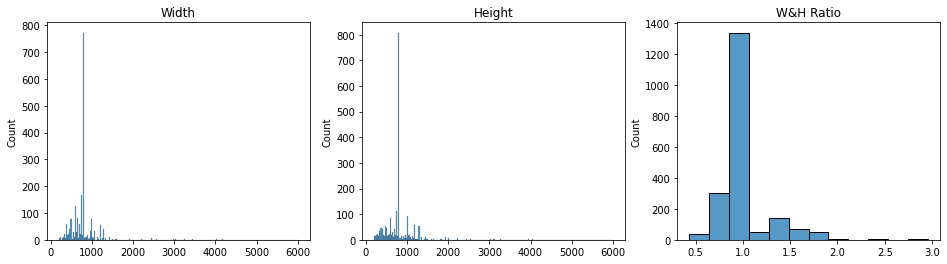

In [4]:
img_dir = osp.join(root, 'images')
import glob
import mmcv
img_paths = glob.glob(img_dir + '/*')
def get_img_size(img_path):
    image = Image.open(img_path)
    w, h = image.size
    return (w, h)

results = mmcv.track_parallel_progress(get_img_size, img_paths, 8)

w_list = [x[0] for x in results]
h_list = [x[1] for x in results]

import seaborn as sns
f, ax = plt.subplots(1,3, figsize=(16,4))
sns.histplot(w_list, ax=ax[0], palette=sns.light_palette("seagreen", as_cmap=True)).set_title('Width');
sns.histplot(h_list, ax=ax[1], palette=sns.color_palette("RdPu", 10)).set_title('Height');
sns.histplot(np.array(w_list)/np.array(h_list), ax=ax[2], palette=sns.color_palette("RdPu", 10)).set_title('W&H Ratio');

大部分都是 `800*800` 的 尺寸，少部分会非常大

# 统计小目标的比例

In [7]:
from pycocotools.coco import COCO
json_path = osp.join(root, 'instances_train2017.json')
coco = COCO(json_path)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [13]:
print('bbox 小目标(area<%3)占比 统计')
class_names = []
wh_ratios_cls = []
for cat_id in coco.cats:
    wh_ratios = []
    for ann_id in coco.getAnnIds(catIds=[cat_id]):
        ann = coco.anns[ann_id]
        image_id = ann['image_id']
        w_ratio = ann['bbox'][2] / coco.imgs[image_id]['width']
        h_ratio = ann['bbox'][3] / coco.imgs[image_id]['height']
        wh_ratios.append([w_ratio, h_ratio])
    wh_ratios = np.array(wh_ratios)
    wh_ratios[:, -1] = wh_ratios[:, 0] * wh_ratios[:, 1]
    # print(coco.cats[cat_id]['name'], (wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])
    class_names.append(coco.cats[cat_id]['name'])
    wh_ratios_cls.append((wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])

wh_ratios = []
for _, ann in coco.anns.items():
    image_id = ann['image_id']
    w_ratio = ann['bbox'][2] / coco.imgs[image_id]['width']
    h_ratio = ann['bbox'][3] / coco.imgs[image_id]['height']
    wh_ratios.append([w_ratio, h_ratio])
wh_ratios = np.array(wh_ratios)
wh_ratios[:, -1] = wh_ratios[:, 0] * wh_ratios[:, 1]
# print('all ', (wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])
class_names.append('all')
wh_ratios_cls.append((wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])

from prettytable import PrettyTable
table_data = PrettyTable()
table_data.add_column('class', class_names)
table_data.add_column('small object ratio', wh_ratios_cls)
print(table_data.get_string())

bbox 小目标(area<%3)占比 统计
+------------------+--------------------+
|      class       | small object ratio |
+------------------+--------------------+
|      FESTO       | 0.8409090909090909 |
|    starbucks     | 0.9523809523809523 |
|     castrol      | 0.8421052631578947 |
|    hellokitty    | 0.7349397590361446 |
|     SANDVIK      |        1.0         |
| alexandermcqueen | 0.8095238095238095 |
|     balabala     |        1.0         |
|  THINKINGPUTTY   |       0.375        |
|       CCTV       |        1.0         |
|       puma       | 0.7777777777777778 |
|      piaget      |        1.0         |
|     givenchy     | 0.7941176470588235 |
|  naturerepublic  | 0.8787878787878788 |
|     pandora      | 0.7307692307692307 |
|   chowtaiseng    |        1.0         |
|       kans       |        1.0         |
|      joyong      |        1.0         |
|      apple       | 0.9428571428571428 |
|      lenovo      |        1.0         |
|   sergiorossi    |        1.0         |
|      joeo

小目标(area<%3) 占据了大部分

# bbox长宽比

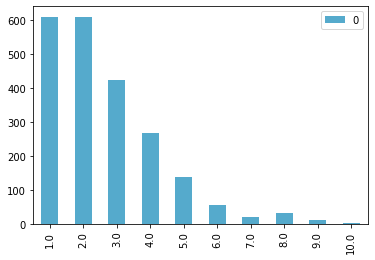

In [14]:
# refer: https://zhuanlan.zhihu.com/p/108885033
bbox_wh = [round(max(ann['bbox'][2], ann['bbox'][3]) / min(ann['bbox'][2], ann['bbox'][3]), 0) for _, ann in coco.anns.items()]
import pandas as pd
bbox_wh_unique = list(set(bbox_wh))
bbox_wh_count=[bbox_wh.count(i) for i in bbox_wh_unique]
k = 10
wh_df = pd.DataFrame(bbox_wh_count[:k], index=bbox_wh_unique[:k])
wh_df.plot(kind='bar',color="#55aacc")
plt.show()